# Evaluate Presidio's accuracy by race and gender
Using US Census data and data from Home Mortgages, generate distributions of names for each race and each gender. Then, evaluate Presidio's accuracy on the generated names.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import choice
from presidio_analyzer import AnalyzerEngine
import multiprocess as mp

# By Race

In [2]:
groups = ["white", "black", "api", "aian", "hispanic"]

def preprocess(df, old_name_col, new_name_col, count_col):
    # Standard preprocessing
    df[new_name_col] = df[old_name_col].str.lower().str.strip()
    df.drop(old_name_col, axis=1, inplace=True)
    df = df.iloc[:-1]  # last row contains aggregation of remaining names
    df = df[~df[new_name_col].isna()]

    # Calculate distributions per group
    for group in groups:
        df[f"pct{group}"] = df[f"pct{group}"].astype(float)
        df[f"ct_{group}"] = df[f"pct{group}"] * df[count_col] / 100
        df[f"prop_{group}"] = df[f"ct_{group}"] / df[f"ct_{group}"].sum()
    return df[[new_name_col] + [f"prop_{group}" for group in groups]]

In [3]:
# LOAD DATA

surnames = pd.read_csv("../assets/names/Names_2010Census.csv").replace("(S)", 0)
surnames = preprocess(surnames, "name", "surname", "count")

forenames = pd.read_excel("../assets/names/firstnames.xlsx", sheet_name=1)
forenames = preprocess(forenames, "firstname", "forename", "obs")

contexts = [
    "dr [name]",
    "[name] dr",
    "google [name]",
    "[name] google",
    "[name] and the",
    "[name] of the",
    "who is [name]",
    "[name] is the",
    "how old is [name]",
    "how to get [name]",
    "[name] what",
    "what happened to [name]",
    "how to make [name]",
    "who had conflict with [name]",
    "what did [name]",
    "who supports [name]",
    "is there any evidence that [name]",
    "what did [name] say",
    "[name] deceased",
    "[name] surgeon",
    "surgeon [name]",
    "[name] group",
    "[name] attorney",
    "attorney [name]",
    "[name] rutracker",
    "rutracker [name]",
    "author [name]",
    "[name] author",
    "lawyer [name]",
    "[name] laywer",
    "[name] home address",
    "[name] university",
    "[name] husband",
    "[name] wife",
    "[name] spouse",
    "[name] 202-456-1111",  # phone number of the white house
    "[name] cashapp",
    "cs [name]",
    "[name] retired",
    "[name] deceased",
    "[name] last known address",
    "[name] tiktok",
    "tiktok [name]",
    "[name] family medicine",
    "[name] twitter",
    "twitter [name]",
    "[name] on social",
    "wik [name]",
    "[name] wik",
    "wiki [name]",
    "[name] wiki",
]

In [4]:
len(contexts)

51

In [5]:
#### NO SEED SET!!!!

iterations = 10**3
sample_size = 10**3
analyzer = AnalyzerEngine()

def contains_presidio_name(x):
    results = analyzer.analyze(text=x, entities=["PERSON"], language='en')
    if len(results) > 0:
        return 1
    return 0

def generate_names(group, sample_size):
    generated = zip(
        choice(forenames.forename, size=sample_size, replace=True, p=forenames[f"prop_{group}"]),
        choice(surnames.surname, size=sample_size, replace=True, p=surnames[f"prop_{group}"])
    )
    return [" ".join(x) for x in generated]

def generate_names_with_context(group, sample_size):
    nms = generate_names(group, sample_size)
    _contexts = choice(contexts, size=sample_size, replace=True)
    generated = [context.replace("[name]", name) for context, name in zip(_contexts, nms)]
    return generated

def get_recall(group, sample_size, generate_fcn, include_context, _iter):
    """`_iter` is a dummy variable.
    """
    generated = generate_fcn(group, sample_size)
    if include_context:
        _contexts = choice(contexts, size=sample_size, replace=True)
        generated = [context.replace("[name]", name) for context, name in zip(_contexts, generated)]
    results = np.array([contains_presidio_name(x) for x in generated])
    return results.mean()

In [4]:
num_workers = mp.cpu_count()  
for g in groups:
    for include_context in [True, False]:
        pool = mp.Pool(num_workers)
        recalls = pool.map(lambda x: get_recall(g, sample_size, generate_names, include_context, x), range(iterations))
        pool.close()
        recalls = np.array(recalls)
        lower = np.percentile(recalls, 2.5)
        upper = np.percentile(recalls, 97.5)
        message = f"{g} forename - {g} surname - include_context: {include_context} - recall: [{lower}, {upper}]\n"
        print(message)

white forename - white surname - include_context: True - recall: [0.913, 0.943]

white forename - white surname - include_context: False - recall: [0.947, 0.971]

black forename - black surname - include_context: True - recall: [0.896, 0.933]

black forename - black surname - include_context: False - recall: [0.93, 0.958]

api forename - api surname - include_context: True - recall: [0.855, 0.896]

api forename - api surname - include_context: False - recall: [0.88, 0.917]

aian forename - aian surname - include_context: True - recall: [0.895, 0.927]

aian forename - aian surname - include_context: False - recall: [0.927, 0.956]

hispanic forename - hispanic surname - include_context: True - recall: [0.888, 0.928]

hispanic forename - hispanic surname - include_context: False - recall: [0.912, 0.94]



## Effect of context

In aggregate, the inclusion of context seems to make spaCy name detection perfom slightly worse. Here we look further into which context strings improve likelihood of detection and which reduce it.

Generate a random sample of names, balanced across race groups, and run Presidio detection.

In [14]:
name_dataset = []
for g in groups:
    name_dataset.append(pd.DataFrame({"group": g, "name": generate_names(g, 200)}))

name_dataset = pd.concat(name_dataset, ignore_index=True)

In [177]:
len(name_dataset)

1000

In [24]:
%%time

name_dataset["presidio_name"] = name_dataset["name"].map(contains_presidio_name).astype(bool)

CPU times: user 4.58 s, sys: 258 ms, total: 4.84 s
Wall time: 5.27 s


Apply each context string to the entire names list and run Presidio detection.

In [29]:
context_dataset = pd.merge(name_dataset, pd.Series(contexts, name="context"), how="cross")
context_dataset["context_name"] = context_dataset.apply(
    lambda r: r["context"].replace("[name]", r["name"]), axis="columns"
)

In [31]:
%%time

context_dataset["presidio_context_name"] = context_dataset["context_name"].map(contains_presidio_name).astype(bool)

CPU times: user 3min 41s, sys: 2.6 s, total: 3min 44s
Wall time: 3min 54s


In [33]:
context_dataset.sample(5)

,group,name,presidio_name,context,context_name,presidio_context_name
37063,aian,deanna maldonado,True,cs [name],cs deanna maldonado,True
46701,hispanic,mayra escobar,True,[name] cashapp,mayra escobar cashapp,True
30103,api,mary gill,True,who had conflict with [name],who had conflict with mary gill,True
46811,hispanic,jorge gastelum,True,[name] twitter,jorge gastelum twitter,True
43306,hispanic,rosa gonzalez,True,[name] is the,rosa gonzalez is the,True


Overall detection rate of names in the sample:

In [92]:
name_dataset["presidio_name"].mean()

0.93

Detection rate by context string:

In [135]:
context_presidio = (
    context_dataset.groupby("context")
    .agg(detection_rate=("presidio_context_name", "mean"))
)

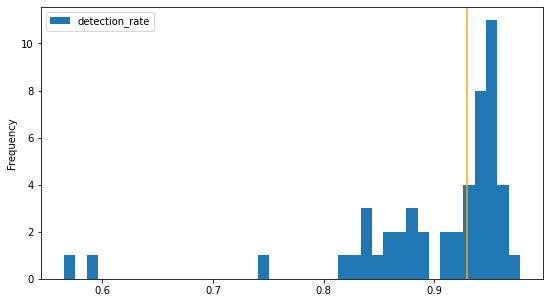

In [136]:
context_presidio.plot.hist(bins=40, figsize=(9,5)).axvline(x=0.93, color="orange")

See the context strings ordered by lowest detection rate (most unhelpful) to highest (most helpful).

In [137]:
context_presidio.sort_values("detection_rate")

,detection_rate
context,
cs [name],0.565
[name] university,0.587
how to make [name],0.746
how to get [name],0.823
[name] group,0.830
rutracker [name],0.836
[name] 202-456-1111,0.837
what happened to [name],0.843
what did [name] say,0.852


What is the effect of context given whether the name is detected by itself or not?

In [164]:
context_by_name = (
    context_dataset.groupby(["presidio_name", "context"])
    .agg(detection_rate=("presidio_context_name", "mean"))
)

Detection rate by context string, split over names that are either not detected (False) or are detected (True) on their own.

array([<AxesSubplot:title={'center':'False'}, ylabel='Frequency'>,
       <AxesSubplot:title={'center':'True'}, ylabel='Frequency'>],
      dtype=object)

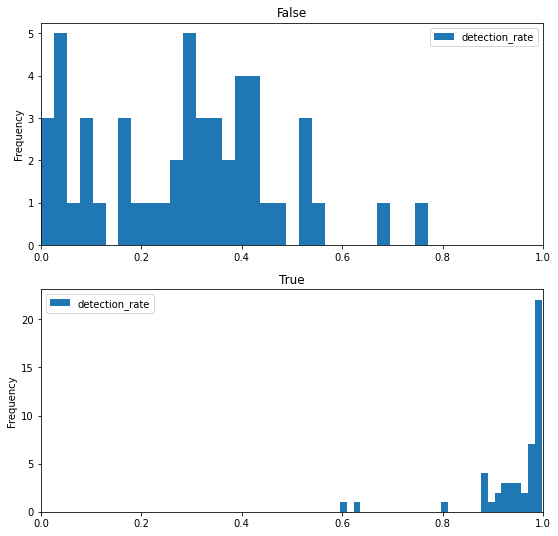

In [178]:
context_by_name.reset_index().plot.hist(by="presidio_name", bins=30, figsize=(9,9), xlim=(0,1))

Context strings for names that are not detected on their own, ordered from most helpful to least.

In [174]:
(
    context_by_name.loc[pd.IndexSlice[False, :],:]
    .droplevel("presidio_name")
    .sort_values("detection_rate", ascending=False)
)

,detection_rate
context,
tiktok [name],0.771429
twitter [name],0.685714
author [name],0.542857
lawyer [name],0.514286
[name] wik,0.514286
[name] tiktok,0.514286
wiki [name],0.471429
[name] twitter,0.442857
[name] dr,0.428571


Context strings for names that are detected on their own, ordered from least helpful to most.

In [176]:
(
    context_by_name.loc[pd.IndexSlice[True, :],:]
    .droplevel("presidio_name")
    .sort_values("detection_rate", ascending=True)
)

,detection_rate
context,
cs [name],0.595699
[name] university,0.630108
how to make [name],0.802151
rutracker [name],0.878495
how to get [name],0.883871
[name] group,0.884946
[name] 202-456-1111,0.888172
google [name],0.901075
what happened to [name],0.904301


# By Gender

In [5]:
groups = ["male", "female"]

def load_forenames(gender):
    df = pd.read_fwf(f"../assets/names/dist.{gender}.first", names=["forename", "pct", "cumpct", "rank"])
    df = df[~df.forename.isna()]
    df["forename"] = df.forename.str.lower().str.strip()
    df["pct"] = df.pct / df.pct.sum()
    df.drop(["cumpct", "rank"], axis=1, inplace=True)
    return df

def load_surnames():
    # Standard preprocessing
    df = pd.read_csv("../assets/names/Names_2010Census.csv").replace("(S)", 0)
    df["surname"] = df["name"].str.lower().str.strip()
    df.drop("name", axis=1, inplace=True)
    df = df.iloc[:-1]  # last row contains aggregation of remaining names
    df = df[~df["surname"].isna()]
    
    # distribution
    df["pct"] = df["count"] / df["count"].sum()
    return df[["surname", "pct"]]

In [6]:
# LOAD DATA

forenames = {
    "male": load_forenames("male"),
    "female": load_forenames("female")
}
surnames = load_surnames()

In [7]:
#### NO SEED SET!!!!

iterations = 10**3
sample_size = 10**3
analyzer = AnalyzerEngine()

def generate_names_with_gender(gender_df, sample_size):
    generated = zip(
        choice(gender_df.forename, size=sample_size, replace=True, p=gender_df.pct),
        choice(surnames.surname, size=sample_size, replace=True, p=surnames.pct)
    )
    return [" ".join(x) for x in generated]


num_workers = mp.cpu_count()  

for gender, gender_df in forenames.items():
    for include_context in [True, False]:
        pool = mp.Pool(num_workers)
        recalls = pool.map(lambda x: get_recall(gender_df, sample_size, generate_names_with_gender, include_context, x), 
                           range(iterations))
        pool.close()
        recalls = np.array(recalls)
        lower = np.percentile(recalls, 2.5)
        upper = np.percentile(recalls, 97.5)
        message = f"{gender} forename - any surname - include_context: {include_context} - recall: [{lower}, {upper}]\n"
        print(message)

male forename - any surname - include_context: True - recall: [0.915, 0.946]

male forename - any surname - include_context: False - recall: [0.948, 0.97]

female forename - any surname - include_context: True - recall: [0.875, 0.916]

female forename - any surname - include_context: False - recall: [0.903, 0.937]

